In [13]:
# In the root of the repo run "pip install --editable ."

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.data.import_data import import_df_from_zip_pkl
from src.data.make_dataset import *

import matplotlib.pyplot as plt

from rdtools.soiling import soiling_srr
from src.features.build_features import *
from src.models.detect_soiling import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def compute_soiling_profile(df):
    _, cleaning_index, cleaning_heights = detect_cleaning_events_with_rollling_avg(df.Power)
    return find_soiling_profile(df, cleaning_index, cleaning_heights)
    

First compare the predicted soiling profile with the actual 

In [19]:
def compare_soiling_profile_with_true(indices, path):    
    _, ax = plt.subplots(len(indices), figsize=(10, 4*len(indices)))
    for i in range(len(indices)):
        df = import_df_from_zip_pkl(path, index=indices[i])
        df = downsample_dataframe(df)
        
        soiling_profile = compute_soiling_profile(df)
        
        ax[i].plot(soiling_profile.soiling_factor, label = "Predicted")
        ax[i].plot(df.Soiling, label = "Actual")
        ax[i].legend()
    plt.show()
    

/home/julius/Aug20_Epri/src/models/detect_soiling.py:56: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  rolling_avg_l = power_signal.rolling(window_size_l).apply(avg_function)
/home/julius/Aug20_Epri/src/models/detect_soiling.py:57: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  rolling_avg_r = power_signal.rolling(window_size_r).apply(avg_function)
/home/julius/Aug20_Epri/src/models/detect_soiling.py:56: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Serie

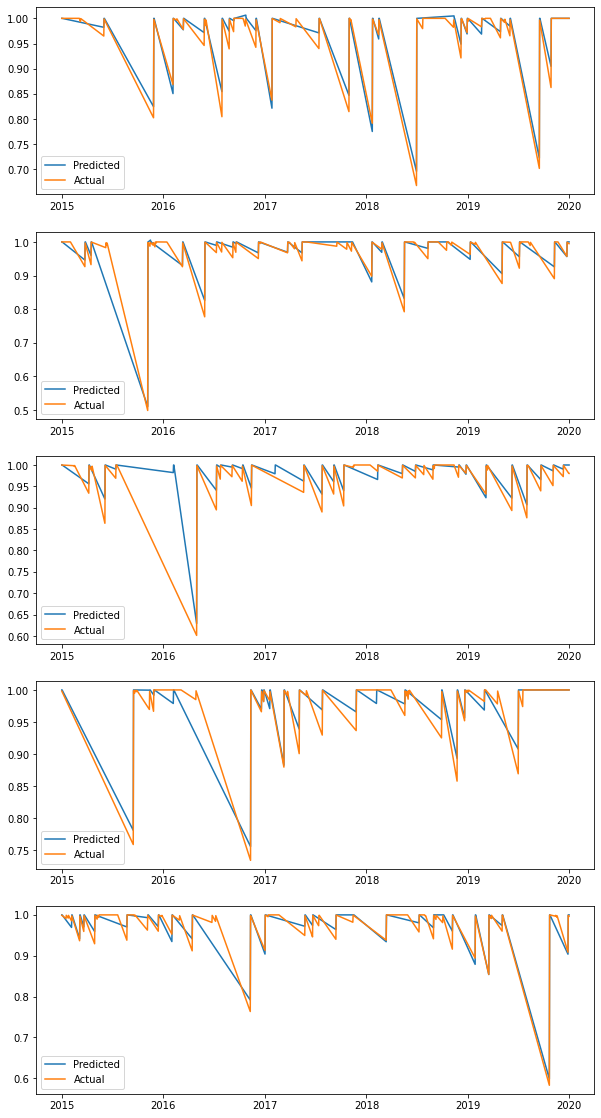

In [20]:
compare_soiling_profile_with_true(range(1, 6), '../data/raw/synthetic_soil.zip' )

Remove the predicted soiling profile from the power signal

In [36]:
# Load a signal
df = import_df_from_zip_pkl('../data/raw/synthetic_soil.zip', index=32)
df = downsample_dataframe(df)

soiling_profile = compute_soiling_profile(df)
normalised_power = (df[['Power']]/soiling_profile.to_numpy())

/home/julius/Aug20_Epri/src/models/detect_soiling.py:56: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  rolling_avg_l = power_signal.rolling(window_size_l).apply(avg_function)
/home/julius/Aug20_Epri/src/models/detect_soiling.py:57: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  rolling_avg_r = power_signal.rolling(window_size_r).apply(avg_function)


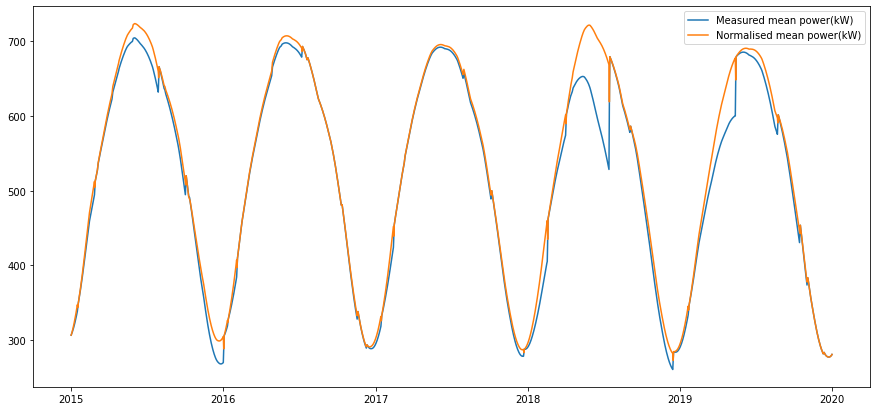

In [37]:
_, ax = plt.subplots(figsize=(15, 7))
ax.plot(df.Power, label='Measured mean power(kW)')
ax.plot(normalised_power, label='Normalised mean power(kW)')
ax.legend()